In [1]:
#Imports
from matplotlib import pyplot as plt
import matplotlib
from sklearn import metrics
import pickle, typing
import numpy as np
import pandas as pd
import scikit_posthocs as sp
from statsmodels.stats.contingency_tables import cochrans_q

In [2]:
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'cmr10'
matplotlib.rcParams['font.size'] = 10

In [3]:
#Constants and global variables
DATA_DIR = 'D:/data'
K = 10
METHODS = ['none', 'cnn', 'border', 'smote', 'over', 'under', 'aug', 'aug_fine']
CLASSIFIERS = ['dtree']
MODELS = ['bert-base-uncased',]
DATASETS = ['antisemitism_two', 'antisemitism_four', 
            'antisemitism_five',  'disaster', 
            'website', 'clothing_rating', 
            'clothing_topic', 'cyberbullying',
            'news_mild_multi', 'news_mild_two',
            'news_multi', 'news_semi_multi',
            'news_severe_multi', 'news_severe_two',
            ]
REPLACEMENTS = {'News ': '',}
METRICS = [metrics.f1_score,]

In [4]:
#Analysis helper functions
def open_analyze_file(method: str, model: str, dataset: str, metric: typing.Callable, classifier: str, micro: bool) -> float:
    '''Open and analyze a prediction and actual results file.'''
    with open(f'{DATA_DIR}/{method}/{model}/predictions-{dataset}-{classifier}', 'rb') as f:
        predictions = np.array(pickle.loads(f.read()).ravel())
    with open(f'{DATA_DIR}/{method}/{model}/test-output-{dataset}', 'rb') as f:
        actual = np.array(pickle.loads(f.read()))
        actual = actual[:-(actual.shape[0] % K)] if actual.shape[0] != predictions.shape[0] else actual
    
    return metric(actual, predictions, average=('micro' if micro else 'macro')) if metric == METRICS[0] else metric(actual, predictions)

def replace_name(name: str, shorten: bool) -> str:
    '''Shorten names.'''
    numbers = ['One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine', 'Ten']
    for number in numbers:
        name = name.replace(number, str(numbers.index(number)+1))
    for replacement in REPLACEMENTS:
        name = name.replace(replacement, REPLACEMENTS[replacement])
    if shorten:
        name = ''.join(word[0] for word in name.split())
    return name

def get_all_preds(methods: list[str], model: str, dataset: str, classifier: str) -> tuple:
    '''Get all predictions from a list of methods.'''
    all_preds = []
    for method in methods:
        with open(f'{DATA_DIR}/{method}/{model}/predictions-{dataset}-{classifier}', 'rb') as f:
            predictions = np.array(pickle.loads(f.read()).ravel())
        with open(f'{DATA_DIR}/{method}/{model}/test-output-{dataset}', 'rb') as f:
            actual = np.array(pickle.loads(f.read()))
            actual = actual[:-(actual.shape[0] % K)] if actual.shape[0] != predictions.shape[0] else actual
        all_preds.append(np.array([prediction == actual[i] for i, prediction in enumerate(predictions)]))
    return all_preds

def visualize_dunn(preds: list[np.ndarray], datasets: list[str], model: str, label: str, lines: int, micro: bool, out: bool = False) -> list[np.ndarray]:
    '''Visualize the results of a post-hoc dunn analysis on a Cochran's Q test using MatPlotLib in a matrix.'''
    names = ['NO', 'CD', 'BS', 'SM', 'RO', 'RU', 'AU', 'AF']
    quotient = len(preds) // lines
    fig, ax = plt.subplots(lines, quotient)
    copies = []
    for index, dataset in enumerate(datasets):
        i, j = index // quotient, index % quotient
        dunn_values = sp.posthoc_dunn(preds[index]).to_numpy()
        copies.append(dunn_values.copy())
        lower = np.tril(dunn_values, k=-1)
        for temp_ind, _ in enumerate(lower):
            for temp_j in range(temp_ind):
                lower[temp_ind, temp_j] = 5.0
        dunn_values = np.ma.array(dunn_values, mask=lower)
        
        cmap = matplotlib.colormaps['viridis']
        cmap.set_bad('w')
        
        ax[i][j].matshow(dunn_values, cmap=cmap)
        
        #remove border
        ax[i][j].spines['top'].set_visible(False)
        ax[i][j].spines['right'].set_visible(False)
        ax[i][j].spines['bottom'].set_visible(False)
        ax[i][j].spines['left'].set_visible(False)
        
        #remove tick marks
        ax[i][j].tick_params(axis=u'both', which=u'both',length=0)
        
        ax[i][j].xaxis.set_major_locator(matplotlib.ticker.FixedLocator(range(len(names))))
        rotation = 0 if out else 90
        #ax[i][j].set_xticklabels(labels=(names if i == quotient-1 else []), rotation=rotation)
        ax[i][j].set_xticklabels(labels=[], rotation=rotation)
        ax[i][j].yaxis.set_major_locator(matplotlib.ticker.FixedLocator(range(len(names))))
        ax[i][j].set_yticklabels(labels=(names if j == 0 else []))
        
        for (x, y), z in np.ndenumerate(dunn_values):
            if out and y >= x:
                ax[i][j].text(y, x, ('{:0.1f}'.format(z)).replace('0.0', '0').replace('1.0', '1'), ha='center', va='center')
            elif y >= x:
                ax[i][j].text(y, x, '{:0.1f}'.format(z), ha='center', va='center')
        
        ax[i][j].set_title(dataset.replace('_', ' ').title())
        
    if out:
        #fig = ax.get_figure()
        fig.savefig(f'output/{model}-{micro}-{label}.pdf', bbox_inches='tight', pad_inches = 0)
            
    plt.pause(0.1)
    return copies

In [5]:
#High-level analysis functions
def analyze_method(method_name: str, model_name: str, metric: typing.Callable, classifier: str, micro: bool) -> np.ndarray:
    '''Analyze a method with a particular model and metric, giving scores on all datasets.'''
    return np.array([open_analyze_file(method_name, model_name, dataset, metric, classifier, micro) for dataset in DATASETS])

def analyze_methods(model_name: str, metric: typing.Callable, classifier: str, micro: bool) -> np.ndarray:
    '''Analyze all methods with a particular model and metric.'''
    return np.array([analyze_method(method, model_name, metric, classifier, micro) for method in METHODS])


True

bert-base-uncased
dtree


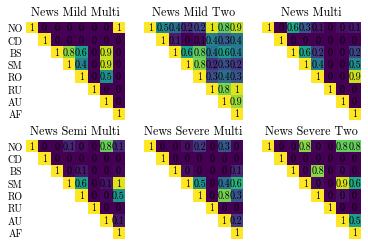

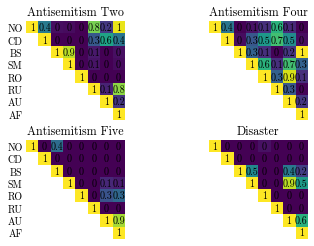

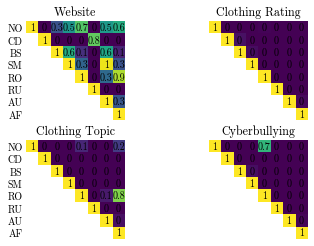

<function f1_score at 0x000002B4A763E440>
              antisemitism_two antisemitism_four antisemitism_five  disaster  \
none                  0.633898          0.457576          0.595082  0.807388   
cnn                   0.617797          0.490909          0.520492   0.73949   
border                0.674576          0.572727          0.613115  0.777836   
smote                 0.677119          0.533333          0.713934  0.781794   
over                  0.728814          0.515152          0.767213  0.818382   
under                 0.638983          0.475758          0.385246  0.717238   
aug                    0.60678          0.518182          0.745082  0.782498   
aug_fine              0.634746          0.572727          0.748361  0.785136   
p                          0.0           0.00001               0.0       0.0   
highest_score         0.728814          0.572727          0.767213  0.818382   
highest                   over            border              over      over  

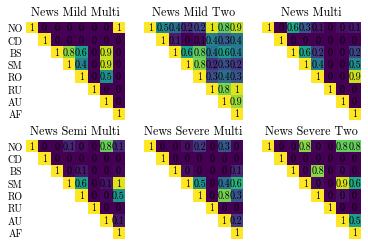

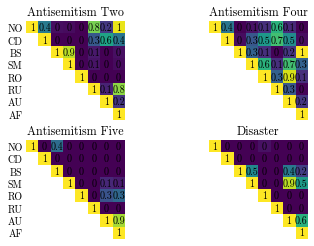

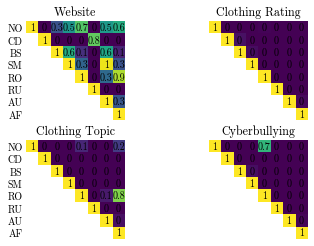

<function f1_score at 0x000002B4A763E440>
              antisemitism_two antisemitism_four antisemitism_five  disaster  \
none                  0.544823          0.321568          0.253697  0.687745   
cnn                   0.589266           0.38652          0.263044  0.649719   
border                 0.61626          0.513863          0.361075  0.678959   
smote                 0.626877          0.454866          0.504536  0.683289   
over                  0.690325          0.465381          0.559738  0.703096   
under                 0.602833          0.369091          0.295344   0.64751   
aug                   0.558001          0.408544          0.567494  0.668007   
aug_fine              0.592235          0.485176          0.575789  0.686439   
p                          0.0           0.00001               0.0       0.0   
highest_score         0.690325          0.513863          0.575789  0.703096   
highest                   over            border          aug_fine      over  

In [6]:
for micro in [True, False]:
    print(f'\n{micro}')
    for model in MODELS:
        print(f'\n{model}')
        for metric in METRICS:
            for classifier in CLASSIFIERS:
                print(classifier)
                df = pd.DataFrame(data=analyze_methods(model, metric, classifier, micro), columns=DATASETS, index=METHODS)
                preds = [get_all_preds(METHODS, model, dataset, classifier) for dataset in DATASETS]
                df.loc['p'] = [cochrans_q(result).pvalue for result in preds]
                
                preds_news = [get_all_preds(METHODS, model, dataset, classifier) for dataset in DATASETS if 'news' in dataset]
                preds_no_news = [get_all_preds(METHODS, model, dataset, classifier) for dataset in DATASETS if 'news' not in dataset]
                news_dunns = visualize_dunn(preds_news, [dataset for dataset in DATASETS if 'news' in dataset], model, 'news', 2, micro, True)
                other_dunns = visualize_dunn(preds_no_news[:4], [dataset for dataset in DATASETS if 'news' not in dataset][:4], model, 'reg2', 2, micro, True)
                other_dunns += visualize_dunn(preds_no_news[4:], [dataset for dataset in DATASETS if 'news' not in dataset][4:], model, 'reg1', 2, micro, True)
                
                latex_df = df.copy()
                for column in [col for col in latex_df.columns.values if 'news' in col]:
                    del latex_df[column]
                latex_df.columns = [replace_name(column.replace('_', ' ').title(), True) for column in latex_df.columns.values]
                latex_df.index = ['NO', 'CD', 'BS', 'SM', 'RO', 'RU', 'AU', 'AF', 'p']
                with open(f'output/LaTeX-{micro}-{model}-{classifier}.tex', 'w') as f:
                    f.write(latex_df.style.format(precision=3).highlight_max(axis=0, props="textbf:--rwrap;").to_latex())
                
                latex_df = df.copy()
                for column in [col for col in latex_df.columns.values if 'news' not in col]:
                    del latex_df[column]
                latex_df.columns = [replace_name(column.replace('_', ' ').title(), False) for column in latex_df.columns.values]
                latex_df.index = ['NO', 'CD', 'BS', 'SM', 'RO', 'RU', 'AU', 'AF', 'p']
                with open(f'output/LaTeX-{micro}-{model}-{classifier}-news.tex', 'w') as f:
                    f.write(latex_df.style.format(precision=3).highlight_max(axis=0, props="textbf:--rwrap;").to_latex())
                
                df.loc['highest_score'] = df.apply(max, axis=0)
                df.loc['highest'] = df.apply('idxmax', axis=0)
                print(metric)
                print(df)
                print('\n\n')
                df.to_csv(f'output/{model}-{classifier}.csv')